# Chapter 11 - I2VIS - Clean version

This is an implementation of a 2D viscous flow code. The energy equation (for temperature) is solved at the cell centers (unlike the example in the chapter 10 notebook, which is solved at the basic nodes.

This notebook puts all of the major function definitions into separate source files and contains only the high-level program code.

In [1]:
# Import necessary packages
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
include("Grid.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")

# note that we import pyplot last to avoid a name conflict with grid.
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Problem setup

100 km sticky air layer, 500x500 km box

In [41]:
struct Materials
    # 1 - mantle
    # 2 - plume
    # 3 - sticky air
    alpha::Vector{Float64}
    rho0::Vector{Float64}
    Hr::Vector{Float64}
    Cp::Vector{Float64}
    kThermal::Vector{Float64}
    eta::Vector{Float64}
    function Materials()
         # These are the values used in Gerya's problem 11.1
         new([3e-5,2e-5,0.0],[3300.,3200.,1.0],[2e-8,3e-8,0.0],[1000.,1000.,3.3e6],[3.0,2.0,300.0],[1e21,1e20,1e17])
    end    
end

function update_marker_density!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    
    for i in 1:markers.nmark                
        # receompute density using the current temperature value
        # assume reference temperature is 273.0
        markers.scalars[rho,i] = materials.rho0[mmat[i]]*(1.0-materials.alpha[mmat[i]]*(markers.scalars[T,i]-273.0)) 
    end
end

# function initialize_marker_properties!(markers::Markers,materials::Materials)
#     eta = markers.scalarFields["eta"]
#     T = markers.scalarFields["T"]
#     mmat = markers.integerFields["material"]
#     for i in 1:markers.nmark                
#         markers.scalars[eta,i] = materials.eta[mmat[i]]
#     end
# end

function initial_conditions!(markers::Markers,materials::Materials)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        mr = ((mx-2.5e5)^2 + (my-2.5e5)^2)^0.5
        if my < 1e5
             # sticky air
             markers.integers[material,i] = 3
             markers.scalars[T,i] = 273.0
             markers.scalars[eta,i] = materials.eta[3]            
         elseif mr < 1e5
             # plume
             markers.integers[material,i] = 2
             markers.scalars[T,i] = 1800.0
             markers.scalars[eta,i] = materials.eta[2]
         else
            # ambient mantle
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 1500.0            
            markers.scalars[eta,i] = materials.eta[1]
         end
    end
    update_marker_density!(markers,materials)
end

initial_conditions! (generic function with 1 method)

# i2vis procedure

0. Set up the Eulerian grid and Lagrangian markers. Distribute the markers within the domain and assign initial conditions.
1. Compute density and viscosity at the basic nodes. Compute cell center viscosity via averaging.
2. Assemble and solve the Stokes equations.
3. Compute the maximum timestep from the velocity field and CFL number.
3. Transfer temperature from markers to basic nodes.
4. Compute the new temperature solution.
5. If the maximum temperature change exceeds a specified value, reduce the timstep and repeat step 4.
6. Compute the subgrid temperature changes and update the temperature on the markers.
7. Move the markers using 2nd order Runge-Kutta

In [57]:
function run(nstep::Int64)
    nstep=2

    nx = 251
    ny = 251
    W = 5e5
    H = 5e5
    gx = 0.0
    gy = 10.0

    Tbcval = [0.0,0.0,273.0,1500.0]
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()
    
    markx = 5
    marky = 5
    seconds_in_year = 3.15e7
    plot_interval = 1e5*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["T","rho","eta"],["material"] ; nmx=markx,nmy=marky,random=false)
    println("Initial condition...")
    @time initial_conditions!(markers, materials)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);
    Cp = 1250. .* ones(grid.ny,grid.nx);
    H = zeros(grid.ny,grid.nx);
    # fill!(rho,3200.);
    # fill!(kThermal,3.0);
    # fill!(Cp,1000.);

    time = 0.0
    iout=0
    last_plot = 0.0


    local rho
    local eta_s
    local T
    local dt
    local dTmax
    local dTemp
    local Tnew
    local Tlast

    output_dir = "test"
    for itime in 1:nstep
        # Get density and viscosity from the markers.
        rho_new,eta_s_new = marker_to_basic_node(markers,grid,["rho","eta"]);

        if time > 0.0
            nanind = findall(isnan.(rho_new))
            rho_new[nanind] = rho[nanind]
            eta_s_new[nanind] = eta_s[nanind]     
        end

        rho   = copy(rho_new)
        eta_s = copy(eta_s_new) 

        eta_n = viscosity_to_cell_centers(grid,eta_s_new)

        # assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s_new,eta_n,rho_new,bc,gx,gy)
        solution = L\R
        vx,vy,P = unpack(solution,grid;ghost=true)
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        dt = compute_timestep(grid,vxc,vyc;dtmax=dtmax)

        # get temperature at cell centers
        Tlast, = marker_to_cell_center(markers,grid,["T",])
        Tlast = ghost_temperature_center(grid,Tlast,Tbcval);
        if time > 0.0
            nanind = findall(isnan.(Tlast))
            Tlast[nanind] = T[nanind]
        end

        dTmax = Inf
        while dTmax >= 20.0 # limit maximum temperature change
            # assemble and solve the energy equation
            println("Trying with timestep ",dt)
            L,R = assemble_energy_equation_center(grid,rho,Cp,kThermal,H,Tlast,dt,Tbcval);
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbcval);

            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp[2:end-1,2:end-1]))
            println("dTmax=",dTmax," dt=",dt)
            dt = min(dt,dTmax < 20.0 ? dt : dt/2)
        end

        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node
    #     dT_remaining = dTemp
        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

        if time == 0.0 || time - last_plot >= plot_interval
            last_plot = time 
            name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
            vn = velocity_to_basic_nodes(grid,vxc,vyc)

        visualization(grid,rho,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
            name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
            visualization(markers,time/seconds_in_year;filename=name)
            iout += 1


    #         figure()
    #         plot(grid.xc,Tnew[5,:])
    #         show()
        end

        move_markers_rk2!(markers,grid,vxc,vyc,dt)
        time += dt
        println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
    end
end
@time run(5)

Creating Markers...
  0.048024 seconds (19 allocations: 87.121 MiB, 31.58% gc time)
Initial condition...
  1.079888 seconds (17.19 M allocations: 265.234 MiB, 24.60% gc time)
Trying with timestep 3.430861324102737e11
dTmax=303.16458667577734 dt=3.430861324102737e11
Trying with timestep 1.7154306620513684e11
dTmax=224.97786884806942 dt=1.7154306620513684e11
Trying with timestep 8.577153310256842e10
dTmax=175.21021225305225 dt=8.577153310256842e10
Trying with timestep 4.288576655128421e10
dTmax=143.92365266689598 dt=4.288576655128421e10
Trying with timestep 2.1442883275642105e10
dTmax=122.236321786676 dt=2.1442883275642105e10
Trying with timestep 1.0721441637821053e10
dTmax=104.28814434038026 dt=1.0721441637821053e10
Trying with timestep 5.360720818910526e9
dTmax=86.91361312720221 dt=5.360720818910526e9
Trying with timestep 2.680360409455263e9
dTmax=69.00965978425029 dt=2.680360409455263e9
Trying with timestep 1.3401802047276316e9
dTmax=51.087568924869174 dt=1.3401802047276316e9
Trying w

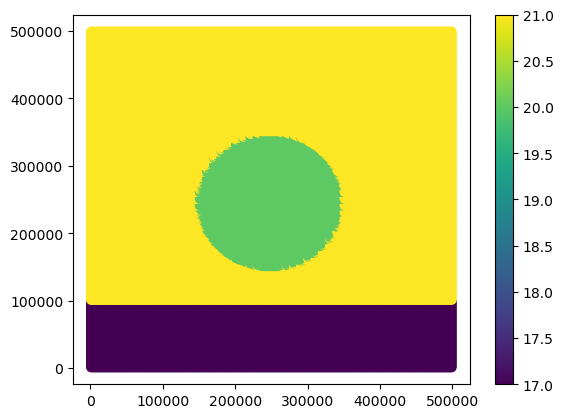

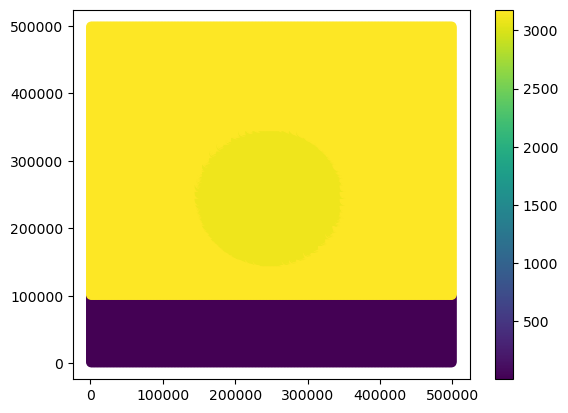

In [40]:
figure()
scatter(markers.x[1,1:markers.nmark],markers.x[2,1:markers.nmark],c=log10.(markers.scalars[markers.scalarFields["eta"],1:markers.nmark]))
colorbar()
show()
figure()
scatter(markers.x[1,1:markers.nmark],markers.x[2,1:markers.nmark],c=(markers.scalars[markers.scalarFields["rho"],1:markers.nmark]))
colorbar()
show()

Creating Markers...
  0.017648 seconds (19 allocations: 87.121 MiB)
Initial condition...
  1.170232 seconds (17.19 M allocations: 265.234 MiB, 3.87% gc time)
Trying with timestep 3.430861324102737e11
dTmax=303.16458667577734 dt=3.430861324102737e11
Trying with timestep 1.7154306620513684e11
dTmax=224.97786884806942 dt=1.7154306620513684e11
Trying with timestep 8.577153310256842e10
dTmax=175.21021225305225 dt=8.577153310256842e10
Trying with timestep 4.288576655128421e10
dTmax=143.92365266689598 dt=4.288576655128421e10
Trying with timestep 2.1442883275642105e10
dTmax=122.236321786676 dt=2.1442883275642105e10
Trying with timestep 1.0721441637821053e10
dTmax=104.28814434038026 dt=1.0721441637821053e10
Trying with timestep 5.360720818910526e9
dTmax=86.91361312720221 dt=5.360720818910526e9
Trying with timestep 2.680360409455263e9
dTmax=69.00965978425029 dt=2.680360409455263e9
Trying with timestep 1.3401802047276316e9
dTmax=51.087568924869174 dt=1.3401802047276316e9
Trying with timestep 6.70

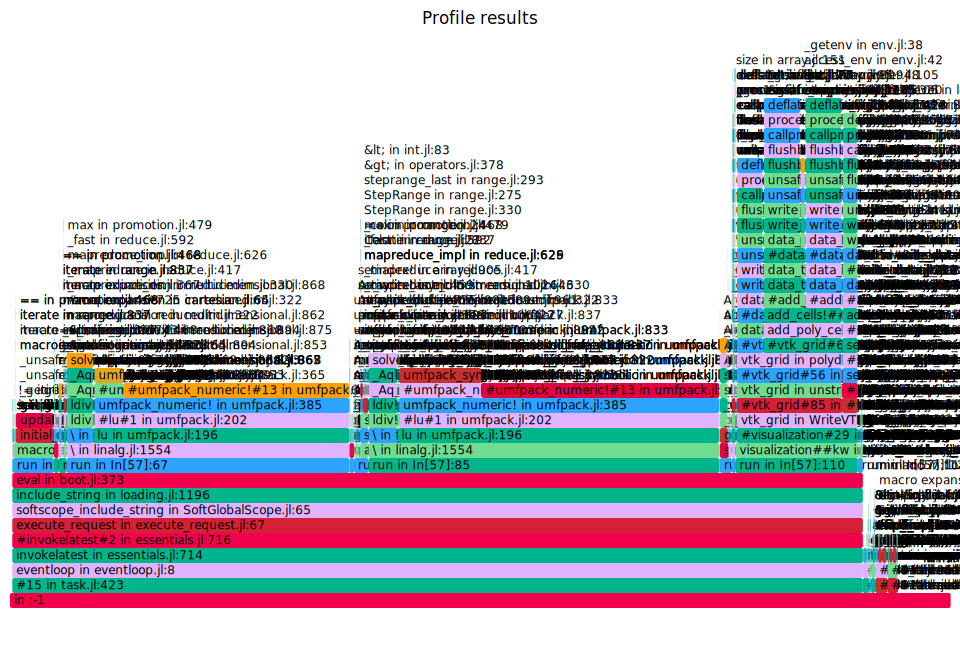

In [59]:
using Profile, ProfileSVG
@profview run(5)
